# Analyzing Carbon Dioxide Removal (CDR) Metrics

This notebook performs a Carbon Dioxide Removal (CDR) analysis using C-Star model output and grid data. We 

* compute CDR efficiency curves
* visualize the results
* and save a dedicated CDR dataset to NetCDF for further analysis or verification.

In [1]:
from roms_tools import Grid, ROMSOutput

First, we read the grid data from a file. For more details, see [this page](https://roms-tools.readthedocs.io/en/latest/grid.html#Creating-a-grid-from-an-existing-NetCDF-or-YAML-file) on creating a grid from an existing NetCDF (or YAML) file.

In [2]:
grid = Grid.from_file("/global/cfs/projectdirs/m4746/Datasets/ROMSOutput/gom12km/grid_12km.nc")

Next, we read the C-Star model output. For more details, see [this page](https://roms-tools.readthedocs.io/en/latest/reading_roms_output.html) on reading ROMS output data.

In [3]:
roms_output = ROMSOutput(
    grid=grid,
    path=[
        "/global/cfs/projectdirs/m4746/Datasets/ROMSOutput/gom12km/atlas_cdr1_cstar.nc"
    ],
    use_dask=True,
)

In [4]:
roms_output.ds

<xarray.Dataset> Size: 32GB
Dimensions:         (time: 182, eta_rho: 130, xi_rho: 210, s_rho: 50)
Coordinates:
    abs_time        (time) datetime64[ns] 1kB 2000-01-02 ... 2000-07-01
    lat_rho         (eta_rho, xi_rho) float64 218kB ...
    lon_rho         (eta_rho, xi_rho) float64 218kB ...
Dimensions without coordinates: time, eta_rho, xi_rho, s_rho
Data variables: (12/22)
    ocean_time      (time) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    zeta            (time, eta_rho, xi_rho) float64 40MB dask.array<chunksize=(1, 130, 210), meta=np.ndarray>
    temp            (time, s_rho, eta_rho, xi_rho) float64 2GB dask.array<chunksize=(1, 50, 130, 210), meta=np.ndarray>
    salt            (time, s_rho, eta_rho, xi_rho) float64 2GB dask.array<chunksize=(1, 50, 130, 210), meta=np.ndarray>
    ALK             (time, s_rho, eta_rho, xi_rho) float64 2GB dask.array<chunksize=(1, 50, 130, 210), meta=np.ndarray>
    DIC             (time, s_rho, eta_rho, xi_rho) float64 2GB dask.array<chunksize=(1, 50, 130, 210), meta=np.ndarray>
    ...              ...
    ALK_source      (time, s_rho, eta_rho, xi_rho) float64 2GB dask.array<chunksize=(1, 50, 130, 210), meta=np.ndarray>
    ALK_ALT_source  (time, s_rho, eta_rho, xi_rho) float64 2GB dask.array<chunksize=(1, 50, 130, 210), meta=np.ndarray>
    DIC_source      (time, s_rho, eta_rho, xi_rho) float64 2GB dask.array<chunksize=(1, 50, 130, 210), meta=np.ndarray>
    DIC_ALT_source  (time, s_rho, eta_rho, xi_rho) float64 2GB dask.array<chunksize=(1, 50, 130, 210), meta=np.ndarray>
    avg_begin_time  (time) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    avg_end_time    (time) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/44)
    global_x:           208
    global_y:           128
    title:              GoM Atlas CDR runs
    grid_file:          ../input_files/partitioned_files/grid_12km.000.nc
    forcing_files:       ../input_files/partitioned_files/surf_frc_phys_20000...
    forcing_info:       
    ...                 ...
    pipe_frc_options:   OFF
    particle_options:   OFF
    git_version:        3e02f2d1a2e10b3fb848e5197ea9b360269fb44a
    averaging:          All variables are averaged in time
    history:            Tue Oct  7 16:32:36 2025: ncrcat ../atlas_cdr1_cstar....
    NCO:                netCDF Operators version 4.9.3 (Homepage = http://nco...

In this experiment, an alkalinity source has been added into the Gulf of Mexico off the coast of the Yucatán Peninsula. This can be visualized by plotting the uppermost layer of `ALK_source`, a variable from the C-Star output. For more details on visualizing ROMS output fields, see [this page](https://roms-tools.readthedocs.io/en/latest/plotting_roms_output.html).

[########################################] | 100% Completed | 100.96 ms


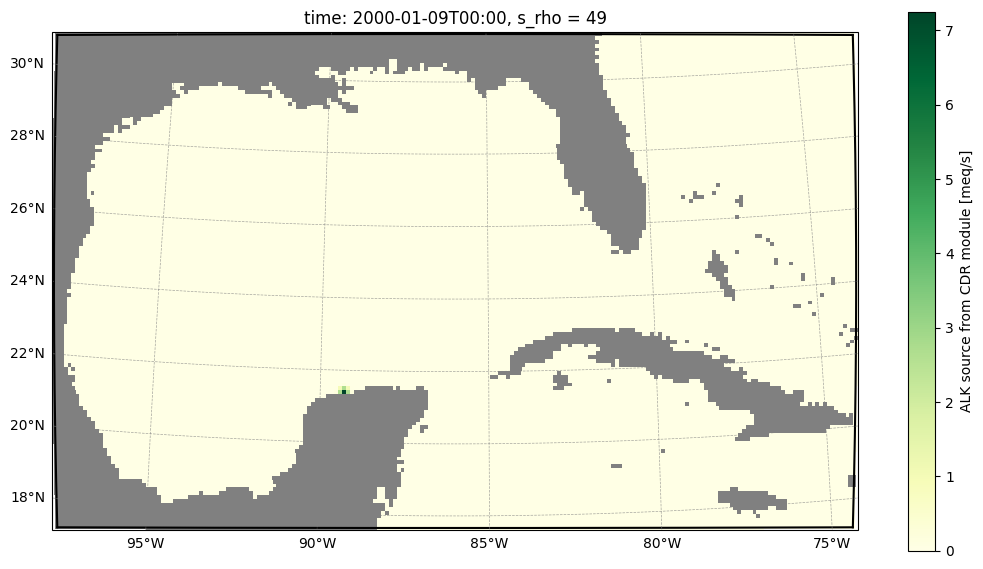

In [5]:
roms_output.plot("ALK_source", s=-1, time=7)

In the next figure, we plot the time series of the total alkalinity source flux.

In [6]:
import matplotlib.pyplot as plt

In [7]:
def plot_alk_flux_series(ds):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(ds.abs_time, ds.ALK_source.sum(dim=["eta_rho", "xi_rho", "s_rho"]))
    ax.set(title="Total alkalinity source flux", xlabel="time", ylabel=ds.ALK_source.attrs["units"])
    ax.grid()    

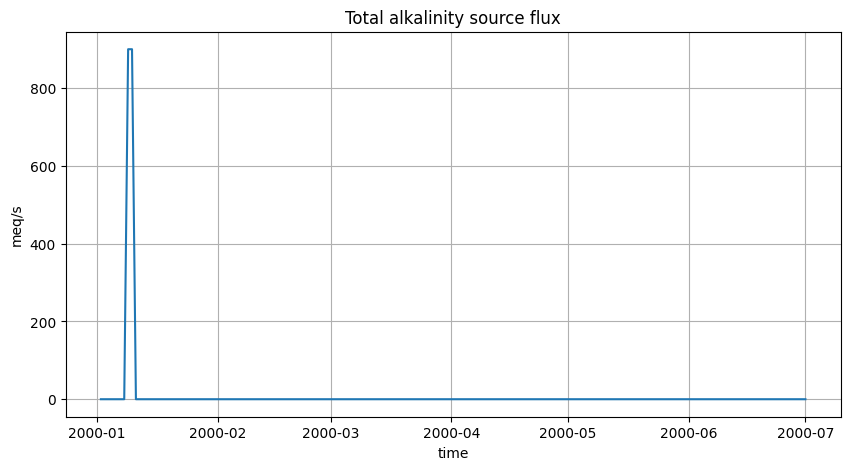

In [8]:
fig = plot_alk_flux_series(roms_output.ds)

The figure indicates that the release has taken place over a short period in early January 2000.

## CDR uptake efficiency

A key metric in CDR analysis is the **CDR uptake efficiency**, which can be computed in two ways (see also [here](https://registry.isometric.com/module/air-sea-gas-exchange/1.0#analysis-of-model-output)):
1. Using CO2 flux differences:
\begin{equation}
\eta_\text{flux}(t_f) =
\frac{
\displaystyle \int_{t_0}^{t_f} \int \big( \Phi_\text{intervention} - \Phi_\text{baseline} \big) \, dA \,  dt
}{
\displaystyle \int_{t_0}^{t_f} \int \big(\text{ALK}_\text{source} + \text{DIC}_\text{sink} \big) \, dV \, dt
}
\end{equation}
3. Using DIC differences:
\begin{equation}
\eta_\text{DIC}(t_f) =
\frac{
\displaystyle \int_{t_0}^{t_f} \int \big( \text{DIC}_\text{intervention} - \text{DIC}_\text{baseline} \big) \, dV \,  dt
}{
\displaystyle \int_{t_0}^{t_f} \int \big(\text{ALK}_\text{source} + \text{DIC}_\text{sink} \big) \, dV \, dt
}
\end{equation}

| Symbol | Meaning | Units |
|--------|---------|-------|
| $t_0$, $t_f$ | Start and end times | s |
| $\Phi_\text{intervention}$ | CO₂ flux with intervention | mol/m²/s |
| $\Phi_\mathrm{baseline}$ | CO₂ flux without intervention | mol/m²/s |
| $\text{DIC}_\text{intervention}$ | DIC with intervention | mol/m³ |
| $\text{DIC}_\text{baseline}$ | DIC without intervention | mol/m³ |
| $\text{ALK}_\text{source}$ | Added alkalinity (intervention)| mol |
| $\text{DIC}_\text{sink}$ | Removed DIC (intervention)| mol |
| $dA$ | Grid cell area | m² |
| $dV$ | Grid cell volume | m³ |

We can perform a CDR analysis, including computing the CDR uptake efficiency in both ways, by calling the method `.cdr_metrics()`. This method will automatically compute the required diagnostics (if not already present), save them in the attribute `.ds_cdr`, and produce a plot of the uptake efficiency over time.

2025-10-09 11:47:53 - INFO - Max absolute difference between flux-based and DIC-based uptake efficiency: 1.375e-02


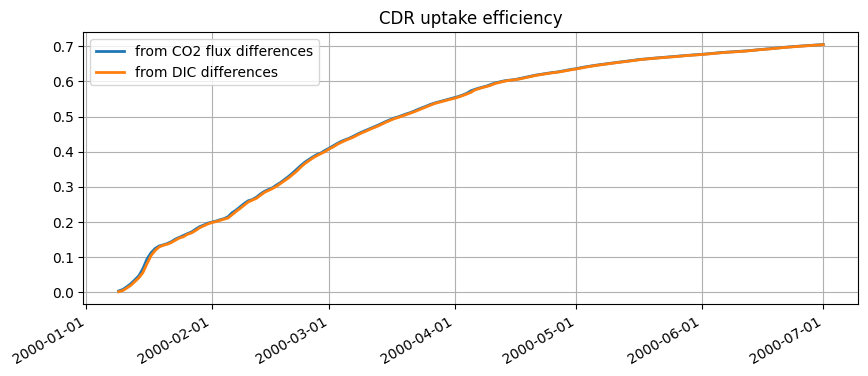

In [9]:
roms_output.cdr_metrics()

## CDR-relevant metrics

After running `.cdr_metrics()`, a new attribute `ds_cdr` is created, containing all CDR-relevant outputs.

In [10]:
roms_output.ds_cdr

<xarray.Dataset> Size: 4GB
Dimensions:                         (time: 182, eta_rho: 130, xi_rho: 210,
                                     s_rho: 50)
Coordinates:
    abs_time                        (time) datetime64[ns] 1kB 2000-01-02 ... ...
    lat_rho                         (eta_rho, xi_rho) float64 218kB 17.08 ......
    lon_rho                         (eta_rho, xi_rho) float64 218kB 262.3 ......
Dimensions without coordinates: time, eta_rho, xi_rho, s_rho
Data variables:
    FG_CO2                          (time, eta_rho, xi_rho) float64 40MB dask.array<chunksize=(1, 130, 210), meta=np.ndarray>
    FG_ALT_CO2                      (time, eta_rho, xi_rho) float64 40MB dask.array<chunksize=(1, 130, 210), meta=np.ndarray>
    hDIC                            (time, s_rho, eta_rho, xi_rho) float64 2GB dask.array<chunksize=(1, 50, 130, 210), meta=np.ndarray>
    hDIC_ALT_CO2                    (time, s_rho, eta_rho, xi_rho) float64 2GB dask.array<chunksize=(1, 50, 130, 210), meta=np.ndarray>
    area                            (eta_rho, xi_rho) float64 218kB 1.419e+08...
    window_length                   (time) float64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    cdr_efficiency                  (time) float64 1kB nan nan ... 0.7043 0.705
    cdr_efficiency_from_delta_diff  (time) float64 1kB nan nan ... 0.7038 0.7045

We can save the CDR-relevant outputs (stored in `.ds_cdr`) to a NetCDF file using xarray's `.to_netcdf()` method.

In [11]:
cdr_filepath = "/pscratch/sd/n/nloose/output/cdr_metrics.nc"

In [12]:
roms_output.ds_cdr.to_netcdf(cdr_filepath)

## Ensembles of CDR efficiency curves

Let's now look at ensembles. For this we have run a second CDR experiment. Let's open its output!

In [13]:
another_roms_output = ROMSOutput(
    grid=grid,
    path=[
        "/global/cfs/projectdirs/m4746/Datasets/ROMSOutput/gom12km/atlas_cdr2_cstar.nc"
    ],
    use_dask=True,
)

The release location is the same as in the first CDR experiment.

[########################################] | 100% Completed | 101.16 ms


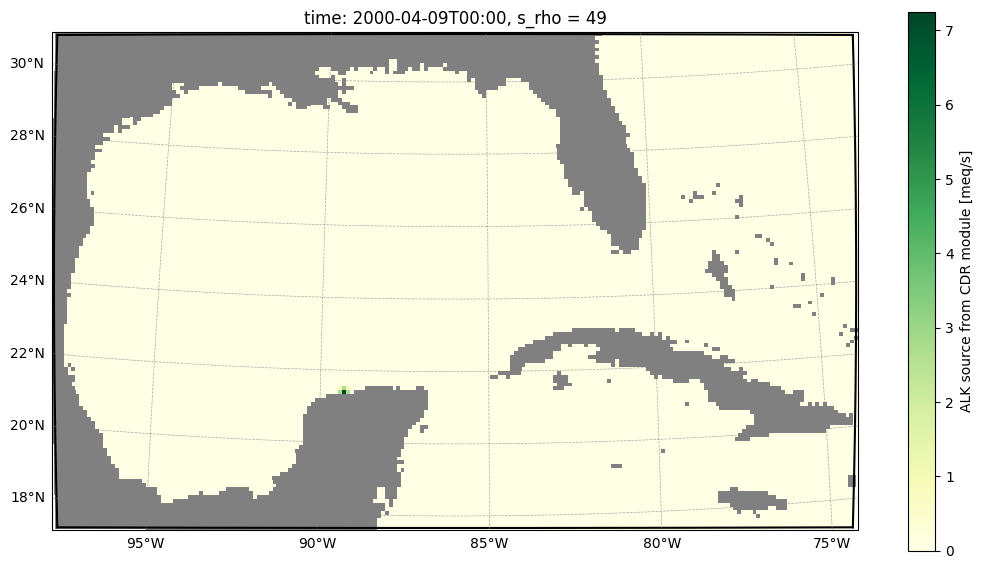

In [14]:
another_roms_output.plot("ALK_source", s=-1, time=7)

However, plotting the total alkalinity source flux indicates that the release occurred over a short period in early April 2000, whereas in the first experiment it took place in early January 2000.

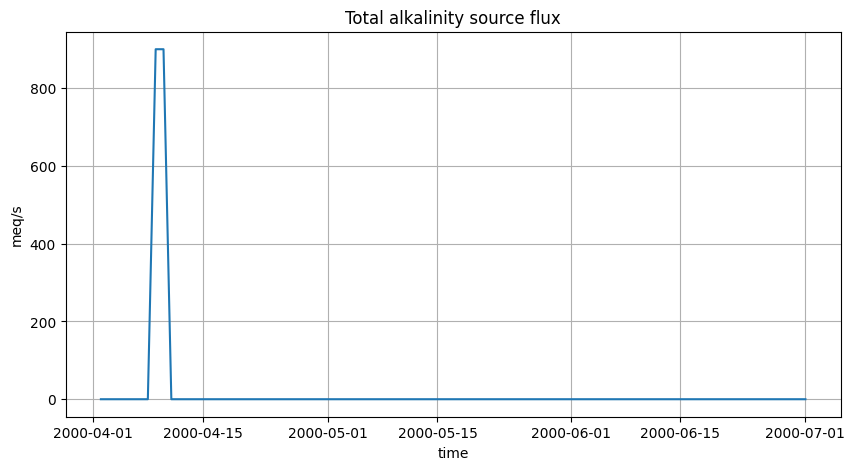

In [15]:
fig = plot_alk_flux_series(another_roms_output.ds)

Note also that the second experiment only ran for three months, while the first ran for six months.

2025-10-09 11:49:38 - INFO - Max absolute difference between flux-based and DIC-based uptake efficiency: 1.088e-02


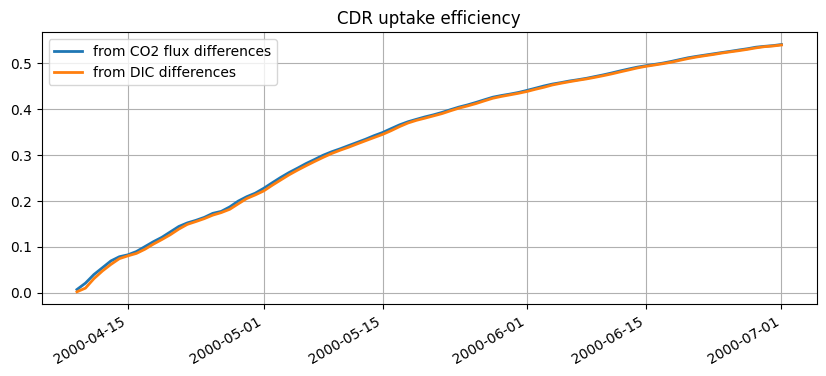

In [16]:
another_roms_output.cdr_metrics()

We can now construct a small ensemble consisting of two members: our two experiments. Note that ensemble members do not need to share the same start or end dates.

In [17]:
from roms_tools import Ensemble

The `members` variable is a dictionary whose values can be either:

* file paths (strings) pointing to the CDR metrics, or
* `xarray.Dataset` objects containing the metrics directly.

Let’s use a mix of both!

In [18]:
ensemble = Ensemble(
    members={
        "January_release": cdr_filepath,
        "April_release": another_roms_output.ds_cdr
    }
)

The `.ds` attribute contains an `xarray.Dataset` that aggregates all releases, aligns them relative to the release start date, and computes the ensemble mean and standard deviation.

In [19]:
ensemble.ds

<xarray.Dataset> Size: 7kB
Dimensions:          (time: 182)
Coordinates:
  * time             (time) timedelta64[s] 1kB -7 days -6 days ... 174 days
Data variables:
    January_release  (time) float64 1kB nan nan nan nan ... 0.7035 0.7043 0.705
    April_release    (time) float64 1kB nan nan nan nan nan ... nan nan nan nan
    ensemble_mean    (time) float64 1kB nan nan nan nan ... 0.7035 0.7043 0.705
    ensemble_std     (time) float64 1kB nan nan nan nan nan ... 0.0 0.0 0.0 0.0

We can make a plot and save it as follows.

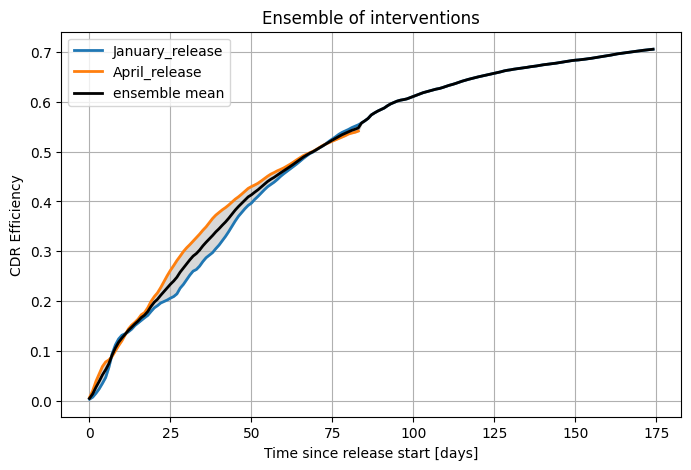

In [20]:
ensemble.plot(save_path="figures/ensemble.png")